In [40]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
import ast
from sklearn.decomposition import PCA
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from math import exp
from math import log

### Question 1

In [2]:
def parseData(fname):
  for l in open(fname):
    yield ast.literal_eval(l)

In [3]:
print("Reading data...")
data = list(parseData("beer_50000.json"))
print("done")

Reading data...
done


In [4]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

In [5]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))


In [6]:
##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

ind_list = [i for i in range(len(X))]
random.shuffle(ind_list)
random_X = []
random_y = []

for i in ind_list:
    random_X.append(X[i])
    random_y.append(y[i])

X_train = random_X[:len(random_X)//3]
y_train = random_y[:len(random_y)//3]

X_test = random_X[len(random_X)//3 + 1:2*len(random_X)//3]
y_test = random_y[len(random_y)//3 + 1:2*len(random_y)//3]

X_val = random_X[2*len(random_X)//3:]
y_val = random_y[2*len(random_y)//3:]

In [7]:
##################################################
# Train                                          #
##################################################

def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [8]:
##################################################
# Predict                                        #
##################################################

def performance(theta, X_test, y_test):
  scores = [inner(theta,x) for x in X_test]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y_test)]
  acc = sum(correct) * 1.0 / len(correct)
  return predictions, acc, scores

In [15]:
##################################################
# Validation pipeline                            #
##################################################

lam = 1.0

theta = train(lam)
train_predictions, train_acc, train_scores = performance(theta, X_train, y_train)
test_predictions, test_acc, test_scores = performance(theta, X_test, y_test)
val_predictions, val_acc, val_scores = performance(theta, X_val, y_val)
print("lambda = " + str(lam))
print("Train:\taccuracy=" + str(train_acc))
print("Test:\taccuracy=" + str(test_acc))
print("Validation:\taccuracy=" + str(val_acc))

lambda = 1.0
Train:	accuracy=0.7214088563542542
Test:	accuracy=0.7146285851434058
Validation:	accuracy=0.7153056938861223


### Question 2

In [16]:
tPos = 0
fPos = 0
tNeg = 0
fNeg = 0

for i in range(len(y_test)):
    if y_test[i] == True and test_predictions[i] == True:
        tPos += 1
    elif y_test[i] == False and test_predictions[i] == True:
        fPos += 1
    elif y_test[i] == False and test_predictions[i] == False:
        tNeg += 1
    else:
        fNeg += 1

print("True Positive: " + str(tPos))
print("False Positive: " + str(fPos))
print("True Negative: " + str(tNeg))
print("False Negative: " + str(fNeg))

True Positive: 9019
False Positive: 3504
True Negative: 2891
False Negative: 1252


### Question 3

In [17]:
test_predictions = list(zip(y_test, test_predictions, test_scores))
test_predictions = sorted(test_predictions, key=lambda x:x[2])


In [34]:
relevantAt100 = sum([1 for v in test_predictions[-100:] if v[0] == True])
retrievedAt100 = sum([1 for v in test_predictions[-100:] if v[1] == True])
relRetrievedAt100 = sum([1 for v in test_predictions[-100:] if v[0] == v[1] and v[0] == True])
totalRelevant = sum([1 for v in test_predictions if v[0] == True])
totalRetrieved = sum([1 for v in test_predictions if v[1] == True])
totalRelRetrieved = sum([1 for v in test_predictions if v[0] == v[1] and v[0] == True])

In [35]:
precisionAt100 = relRetrievedAt100/retrievedAt100
recallAt100 = relRetrievedAt100/relevantAt100
precision = totalRelRetrieved/totalRetrieved
recall = totalRelRetrieved/totalRelevant

In [36]:
print("Precision@100: " + str(precisionAt100))
print("Precision: " + str(precision))
print("Recall@100: " + str(recallAt100))
print("Recall: " + str(recall))

Precision@100: 0.92
Precision: 0.7201948414916554
Recall@100: 1.0
Recall: 0.8781033979164639


### Question 4

In [38]:
precision, recall, _ = precision_recall_curve(y_test, test_scores)

Text(0.5,1,'2-class Precision-Recall curve: AP={0:0.2f}')

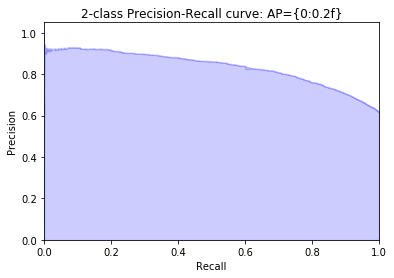

In [47]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}')

### Question 5

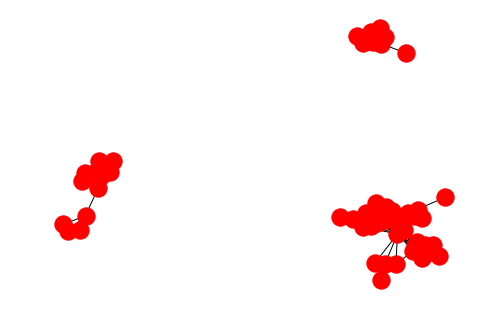

<Figure size 432x288 with 0 Axes>

In [48]:
### Network visualization ###

edges = set()
nodes = set()
for edge in open("egonet.txt"):
  x,y = edge.split()
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)

G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()



In [49]:
connComponents = list(nx.connected_component_subgraphs(G))

In [50]:
for graph in connComponents:
    print(len(graph.nodes))

40
9
12


The graph has 3 connected components and the largest one has 40 nodes

### Question 6

In [155]:
largestCom = connComponents[0]

In [156]:
nodes = list(largestCom.nodes)
edges = list(largestCom.edges)

In [157]:
nodes1 = nodes[:len(nodes)//2]
degrees1 = sum([G.degree(v) for v in nodes1])
nodes2 = nodes[len(nodes)//2:]
degrees2 = sum([G.degree(v) for v in nodes2])

In [158]:
cuttedEdges = sum([1 for e in edges if (e[0] in nodes1 and e[1] in nodes2) or (e[0] in nodes2 and e[1] in nodes1)])

In [159]:
normCut = cuttedEdges/2*(1/degrees1 + 1/degrees2)

In [160]:
print("Normalized-cut cost: " + str(normCut))

Normalized-cut cost: 0.39416666666666667


### Question 7

In [161]:
newCost = 0
while 1:
    costs = []
    for n in nodes:
        newNodes1 = nodes1.copy()
        newNodes2 = nodes2.copy()
        
        if n in nodes1:
            newNodes1.remove(n)
            newNodes2.append(n)
            newDegrees1 = degrees1 - G.degree(n)
            newDegrees2 = degrees2 + G.degree(n)
        else:
            newNodes2.remove(n)
            newNodes1.append(n)
            newDegrees2 = degrees2 - G.degree(n)
            newDegrees1 = degrees1 + G.degree(n)
            
        cuttedEdges = sum([1 for e in edges if (e[0] in newNodes1 and e[1] in newNodes2) or (e[0] in newNodes2 and e[1] in newNodes1)])
        costs.append([n, cuttedEdges/2*(1/newDegrees1 + 1/newDegrees2)])
        
    costs = sorted(costs, key=lambda x:x[1])
    newCost = costs[0][1]
    if costs[0][0] in nodes1:
        nodes1.remove(costs[0][0])
        nodes2.append(costs[0][0])
        degrees1 = degrees1 - G.degree(costs[0][0])
        degrees2 = degrees2 + G.degree(costs[0][0])
    else:
        nodes2.remove(costs[0][0])
        nodes1.append(costs[0][0])
        degrees2 = degrees2 - G.degree(costs[0][0])
        degrees1 = degrees1 + G.degree(costs[0][0])
        
    nodes1.sort()
    nodes2.sort()
    
    if newCost > normCut:
        break
    else:
        normCut = newCost

In [162]:
print(nodes1)

[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 800, 803, 805, 810, 811, 819, 823, 828, 830, 840, 856, 869, 880, 890]


In [163]:
print(nodes2)

[729, 798, 804, 825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893]


In [164]:
print("The new normalized cut cost is " + str(normCut))

The new normalized cut cost is 0.09817045961624274


### Question 8

In [169]:
nodes1 = nodes[:len(nodes)//2]
degrees1 = sum([G.degree(v) for v in nodes1])
nodes2 = nodes[len(nodes)//2:]
degrees2 = sum([G.degree(v) for v in nodes2])

In [170]:
def modularity(c1, c2):
    e00 = sum([1 for e in edges if e[0] in c1 and e[1] in c1])/len(edges)
    e11 = sum([1 for e in edges if e[0] in c2 and e[1] in c2])/len(edges)

    a0 = 0
    a1 = 0
    for e in edges:
        if(e[0] in c1):
            a0 = a0 + 1
        else:
            a1 = a1 + 1

        if(e[1] in c1):
            a0 = a0 + 1
        else:
            a1 = a1 + 1
    a0 = a0/(2*len(edges))
    a1 = a1/(2*len(edges))

    return e00 - a0*a0 + e11 - a1*a1

In [171]:
actualModularity = modularity(nodes1, nodes2)
newModularity = 1
while 1:
    modularities = []
    for n in nodes:
        newNodes1 = nodes1.copy()
        newNodes2 = nodes2.copy()
        
        if n in nodes1:
            newNodes1.remove(n)
            newNodes2.append(n)
            newDegrees1 = degrees1 - G.degree(n)
            newDegrees2 = degrees2 + G.degree(n)
        else:
            newNodes2.remove(n)
            newNodes1.append(n)
            newDegrees2 = degrees2 - G.degree(n)
            newDegrees1 = degrees1 + G.degree(n)
            
        modularities.append([n, modularity(newNodes1, newNodes2)])
        
    modularities = sorted(modularities, key=lambda x:x[1])
    newModularity = modularities[0][1]
    
    if modularities[0][0] in nodes1:
        nodes1.remove(modularities[0][0])
        nodes2.append(modularities[0][0])
        degrees1 = degrees1 - G.degree(modularities[0][0])
        degrees2 = degrees2 + G.degree(modularities[0][0])
    else:
        nodes2.remove(modularities[0][0])
        nodes1.append(modularities[0][0])
        degrees2 = degrees2 - G.degree(modularities[0][0])
        degrees1 = degrees1 + G.degree(modularities[0][0])
        
    nodes1.sort()
    nodes2.sort()
    
    if newModularity > actualModularity:
        break
    else:
        actualModularity = newModularity

In [172]:
print(nodes1)

[697, 703, 708, 729, 745, 769, 772, 774, 803, 804, 810, 811, 819, 823, 825, 830, 863, 864, 876, 889, 893]


In [173]:
print(nodes2)

[713, 719, 747, 753, 798, 800, 805, 828, 840, 856, 861, 869, 878, 880, 882, 884, 886, 888, 890]


In [187]:
print("The new modularity is " + str(actualModularity))

The new modularity is -0.11372933884297518
